<div class="image-container">
  <img class="image" src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Logo-ITESO-Vertical-SinFondo-png.png" width="300" height="300" style="float: right">
</div>


<p>
    <font style = "font-family:Cambria">          
    <h2><font color="#191970" size = 6 >
        001 Modelo de Puntuación crediticia
    </font></h2>         
    <br>         
    <font color='navy' size = 6>Project 1. </font>
    <br> 
    <h3><font size =4>Collaborators:</font></h3> 
    <ul>
        <li>Diego Emilio Enriquez Nares</li>
        <li>Ana Sofia Brizuela Casarin</li>
        <li>Juan Antonio Mugica Liparoli</li>
    </ul>               
    </font>
</p>

In [17]:
# LIBRARIES
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

warnings.filterwarnings("ignore")



In [47]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class CreditScoreModel:
    def __init__(self, filepath):
        # Load the CSV file
        self.df = pd.read_csv(filepath)
        self.bins = [-1, 300, 550, 852]  # Adjusted bins to improve accuracy
        self.columns_to_process_num = []

    # Data cleaning and transformation method
    def clean_and_transform(self):
        # Replace null values
        null_columns = ['Occupation', 'Changed_Credit_Limit', 'Payment_Behaviour', 'Credit_Mix']
        hyphen_columns = ['Age', 'Num_of_Loan', 'Annual_Income', 'Num_of_Delayed_Payment',
                          'Outstanding_Debt', 'Changed_Credit_Limit', 'Amount_invested_monthly',
                          'Monthly_Balance']
        credit_mapping = {'Good': 1, 'Standard': 0, 'Bad': -1, 'Poor': -1}
        payment_min_amount_mapping = {'No': 1, 'Yes': -1, 'NM': 0}
        payment_behaviour_mapping = {
            'High_spent_Small_value_payments': 1, 'Low_spent_Large_value_payments': 5,
            'Low_spent_Medium_value_payments': 4, 'Low_spent_Small_value_payments': 3,
            'High_spent_Medium_value_payments': 2, 'High_spent_Large_value_payments': 6
        }
        
        # Transform the 'Credit_History_Age' column
        self.df['Credit_History_Age_Num'] = self.df['Credit_History_Age'].apply(self.convert_to_numeric)
        
        # Clean specific columns
        for column in null_columns:
            self.replace_with_nulls(column)
        for column in hyphen_columns:
            self.clean_hyphen_columns(column)
        
        # Map categorical columns
        self.df['Credit_Mix_Num'] = self.df['Credit_Mix'].map(credit_mapping)
        self.df['Credit_Score_Num'] = self.df['Credit_Score'].map(credit_mapping)
        self.df['Payment_min_amount_Num'] = self.df['Payment_of_Min_Amount'].map(payment_min_amount_mapping)
        self.df['Payment_Behaviour_Num'] = self.df['Payment_Behaviour'].map(payment_behaviour_mapping)
        
        # Create new columns
        self.df = self.df.dropna()
        self.df['Num_Types_of_Loans'] = self.df['Type_of_Loan'].apply(lambda x: x.count(',') + 1 if x not in ['not specified', 'No Data'] else 0)
        self.df['Q_Types_Of_Credits'] = self.df['Num_Credit_Card'] + self.df['Num_of_Loan'] + self.df['Credit_Mix_Num'] + self.df['Num_Types_of_Loans']
        self.df['Payment_History'] = -self.df['Delay_from_due_date'] - self.df['Num_of_Delayed_Payment']
        
        # Drop unnecessary columns
        columns_to_drop = ['ID', 'Customer_ID', 'Name', 'Credit_Mix', 'Payment_of_Min_Amount', 
                           'Payment_Behaviour', 'Type_of_Loan', 'Credit_History_Age']
        self.df = self.df.drop(columns=columns_to_drop)
    
    # Helper methods
    def convert_to_numeric(self, text):
        if pd.isnull(text):
            return None
        parts = re.findall(r'(\d+)\sYears and\s(\d+)\sMonths', text)
        if parts:
            years, months = map(int, parts[0])
            return years + months / 12
        return None

    def replace_with_nulls(self, column):
        values_to_replace = ['_______', '!@9#%8', '_']
        self.df[column] = self.df[column].apply(lambda x: np.nan if x in values_to_replace else x)

    def clean_hyphen_columns(self, column):
        self.df[column] = self.df[column].replace(r'^_+|_+$', '', regex=True).astype(float)

    # Improved scoring model method
    def apply_scoring(self):
        # Refined scoring conditions with adjusted weights
        v_sup, v_ssup, v_tsup, v_usup = 150, 150 / 4 * 3, 150 / 4 * 2, 150 / 4
        v_sup_, v_ssup_, v_tsup_ = 200, 200 / 4 * 3, 200 / 4 * 2

        conditions = {
            'Num_Credit_Card': lambda x: v_sup if x <= 2 else v_ssup if x <= 4 else v_tsup if x <= 6 else v_usup if x <= 8 else 0,
            'Interest_Rate': lambda x: v_sup_ if x < 5 else 0 if x > 20 else v_tsup_,
            'Delay_from_due_date': lambda x: v_sup if x < 5 else 0 if x > 31 else v_tsup,
            'Num_Credit_Inquiries': lambda x: v_sup if x < 0 else v_ssup if x <= 2 else v_tsup if x <= 5 else v_usup if x <= 8 else 0,
            'Outstanding_Debt': lambda x: v_sup if x < 0 else v_ssup if x < 500 else v_tsup if x < 1000 else v_usup if x < 1500 else 0,
            'Credit_Mix_Num': lambda x: v_sup_ if x == 1 else 0 if x == -1 else v_tsup_,
        }
        
        # Apply conditions and calculate the score
        self.df['Puntuation'] = self.df.apply(lambda row: sum(conditions[col](row[col]) for col in conditions), axis=1)
        
        # Assign categories based on the score
        self.df['Our_model'] = self.df['Puntuation'].apply(lambda x: 1 if x >= self.bins[2] else (-1 if x <= self.bins[1] else 0))
        
        # Calculate accuracy
        accuracy = (self.df['Our_model'] == self.df['Credit_Score_Num']).mean()
        print(f"Accuracy: {accuracy * 100:.1f}%")
        
        # Confusion matrix with enhanced visualization
        conf_matrix = confusion_matrix(self.df['Credit_Score_Num'], self.df['Our_model'])
        conf_matrix_df = pd.DataFrame(conf_matrix, index=['Bad', 'Standard', 'Good'], columns=['Bad', 'Standard', 'Good'])
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap='coolwarm', cbar=True, linewidths=1, linecolor='black')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        
        # Density plot with professional styling
        plt.figure(figsize=(12, 6))
        colors = ['#FF5733', '#33C1FF', '#A833FF']
        sns.kdeplot(self.df[self.df['Credit_Score_Num'] == -1]['Puntuation'], label='Bad', fill=True, color=colors[0], alpha=0.6)
        sns.kdeplot(self.df[self.df['Credit_Score_Num'] == 0]['Puntuation'], label='Standard', fill=True, color=colors[1], alpha=0.6)
        sns.kdeplot(self.df[self.df['Credit_Score_Num'] == 1]['Puntuation'], label='Good', fill=True, color=colors[2], alpha=0.6)
        plt.axvline(self.bins[1], color='grey', linestyle='--', label='Threshold b1')
        plt.axvline(self.bins[2], color='grey', linestyle='--', label='Threshold b2')
        plt.title('Density Plot of Credit Scores by Type', fontsize=16, fontweight='bold')
        plt.xlabel('Score Sum', fontsize=14)
        plt.ylabel('Density', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)
        plt.grid(visible=True, linestyle='--', linewidth=0.5)
        plt.show()
        
        # Histogram of differences with refined style
        self.df['Differences'] = abs(self.df['Credit_Score_Num'] - self.df['Our_model'])
        plt.figure(figsize=(10, 6))
        counts, bins, patches = plt.hist(self.df['Differences'], bins=[-0.5, 0.5, 1.5, 2.5], color='#33AFFF', edgecolor='black')
        for count, bin, patch in zip(counts, bins, patches):
            height = patch.get_height()
            plt.text(patch.get_x() + patch.get_width() / 2, height + 0.1, f'{int(count)}', ha='center', va='bottom', fontsize=12)
        plt.xticks([0, 1, 2], labels=['No Difference', 'Small Difference', 'Large Difference'], fontsize=12)
        plt.title('Histogram of Differences Between Actual and Predicted Values', fontsize=16, fontweight='bold')
        plt.xlabel('Difference', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.grid(visible=True, linestyle='--', linewidth=0.5)
        plt.show()

    # Method to process numerical columns into bins and display mean scores
    def process_columns(self):
        copy = self.df.copy()
        for column in self.columns_to_process_num:
            bin_column = f'bins_{column}'
            copy[bin_column] = pd.qcut(copy[column], 10, duplicates='drop')
            mean_credit_score = copy.groupby(bin_column)['Credit_Score_Num'].mean()
            print(f"Mean Credit_Score_Num for {bin_column}:")
            print(mean_credit_score)
            mean_credit_score.plot(kind='bar', title=f'Mean Credit_Score_Num for {bin_column}', color='#5D6D7E', edgecolor='black')
            plt.xlabel('Bins')
            plt.ylabel('Mean Credit Score')
            plt.xticks(rotation=45, fontsize=12)
            plt.yticks(fontsize=12)
            plt.title(f'Mean Credit_Score_Num for {bin_column}', fontsize=14, fontweight='bold')
            plt.grid(visible=True, linestyle='--', linewidth=0.5)
            plt.show()
            print("\n\n")

    # Method to run the full analysis
    def run_full_analysis(self):
        self.clean_and_transform()
        self.apply_scoring()
        self.process_columns()



Accuracy: 61.7%


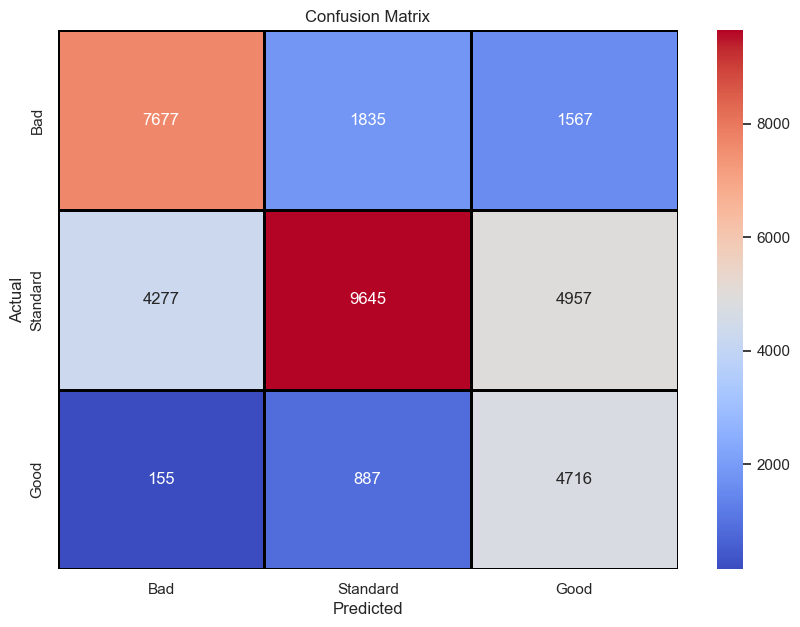

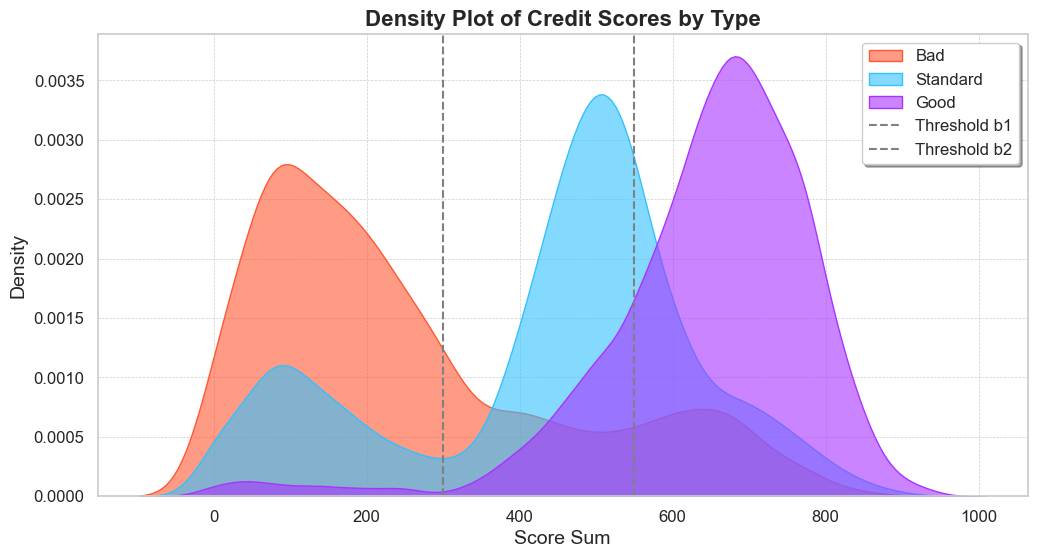

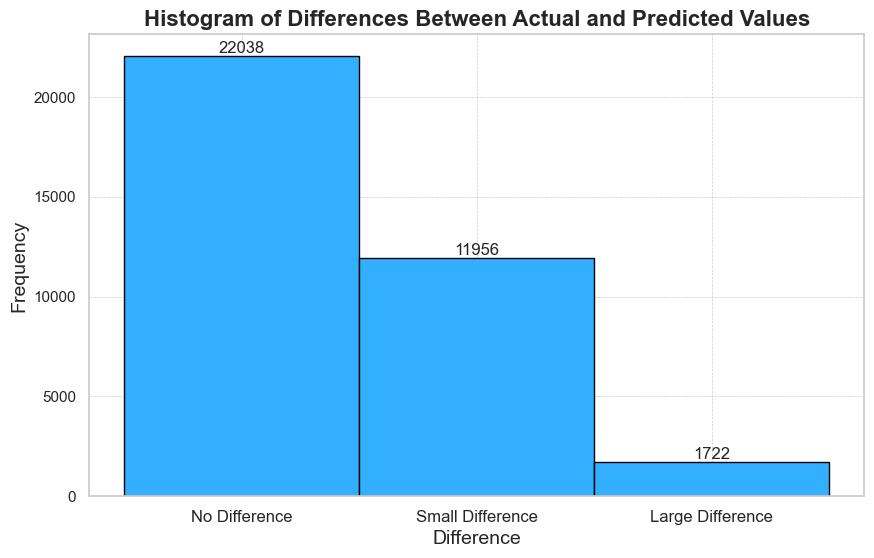

Mean Credit_Score_Num for bins_Interest_Rate:
bins_Interest_Rate
(0.999, 5.0]      0.273763
(5.0, 7.0]        0.170876
(7.0, 9.0]        0.117999
(9.0, 12.0]       0.168442
(12.0, 15.0]     -0.137763
(15.0, 17.0]     -0.302072
(17.0, 20.0]     -0.303214
(20.0, 24.0]     -0.658194
(24.0, 30.0]     -0.634856
(30.0, 5797.0]   -0.495633
Name: Credit_Score_Num, dtype: float64


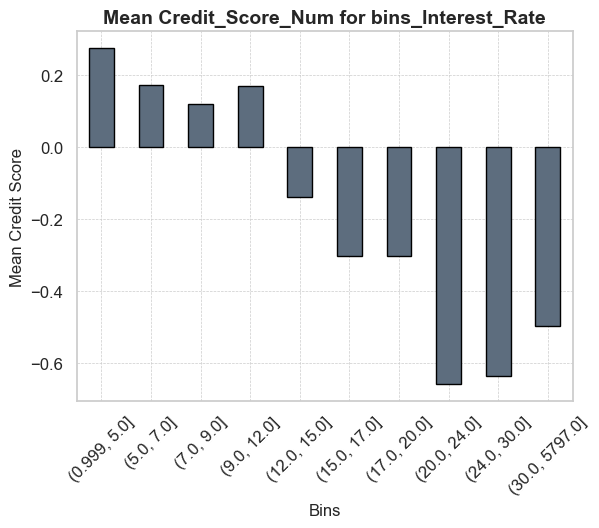

In [48]:
model = CreditScoreModel('Data/train-2.csv')
model.columns_to_process_num = ['Interest_Rate'] # Histogramas
model.run_full_analysis() # Accuracy modelo, graficas de densidad, e histograma de las diferencias entre las variables predichas y las reales

### PRUEBAS

In [61]:
class CreditScoreModel:
    def __init__(self, filepath):
        # Load the CSV file
        self.df = pd.read_csv(filepath)
        self.bins = [-1, 300, 550, 852]  # Adjusted bins to improve accuracy
        self.columns_to_process_num = []

    # Data cleaning and transformation method
    def clean_and_transform(self):
        # Replace null values
        null_columns = ['Occupation', 'Changed_Credit_Limit', 'Payment_Behaviour', 'Credit_Mix']
        hyphen_columns = ['Age', 'Num_of_Loan', 'Annual_Income', 'Num_of_Delayed_Payment',
                          'Outstanding_Debt', 'Changed_Credit_Limit', 'Amount_invested_monthly',
                          'Monthly_Balance']
        credit_mapping = {'Good': 1, 'Standard': 0, 'Bad': -1, 'Poor': -1}
        payment_min_amount_mapping = {'No': 1, 'Yes': -1, 'NM': 0}
        payment_behaviour_mapping = {
            'High_spent_Small_value_payments': 1, 'Low_spent_Large_value_payments': 5,
            'Low_spent_Medium_value_payments': 4, 'Low_spent_Small_value_payments': 3,
            'High_spent_Medium_value_payments': 2, 'High_spent_Large_value_payments': 6
        }

        # Transform the 'Credit_History_Age' column
        self.df['Credit_History_Age_Num'] = self.df['Credit_History_Age'].apply(self.convert_to_numeric)

        # Clean specific columns
        for column in null_columns:
            self.replace_with_nulls(column)
        for column in hyphen_columns:
            self.clean_hyphen_columns(column)

        # Map categorical columns
        self.df['Credit_Mix_Num'] = self.df['Credit_Mix'].map(credit_mapping)
        self.df['Credit_Score_Num'] = self.df['Credit_Score'].map(credit_mapping)
        self.df['Payment_min_amount_Num'] = self.df['Payment_of_Min_Amount'].map(payment_min_amount_mapping)
        self.df['Payment_Behaviour_Num'] = self.df['Payment_Behaviour'].map(payment_behaviour_mapping)

        # Create new columns
        self.df = self.df.dropna()
        self.df['Num_Types_of_Loans'] = self.df['Type_of_Loan'].apply(lambda x: x.count(',') + 1 if x not in ['not specified', 'No Data'] else 0)
        self.df['Q_Types_Of_Credits'] = self.df['Num_Credit_Card'] + self.df['Num_of_Loan'] + self.df['Credit_Mix_Num'] + self.df['Num_Types_of_Loans']
        self.df['Payment_History'] = -self.df['Delay_from_due_date'] - self.df['Num_of_Delayed_Payment']

        # Drop unnecessary columns
        columns_to_drop = ['ID', 'Customer_ID', 'Name', 'Credit_Mix', 'Payment_of_Min_Amount', 
                           'Payment_Behaviour', 'Type_of_Loan', 'Credit_History_Age']
        self.df = self.df.drop(columns=columns_to_drop)

    # Helper methods
    def convert_to_numeric(self, text):
        if pd.isnull(text):
            return None
        parts = re.findall(r'(\d+)\sYears and\s(\d+)\sMonths', text)
        if parts:
            years, months = map(int, parts[0])
            return years + months / 12
        return None

    def replace_with_nulls(self, column):
        values_to_replace = ['_______', '!@9#%8', '_']
        self.df[column] = self.df[column].apply(lambda x: np.nan if x in values_to_replace else x)

    def clean_hyphen_columns(self, column):
        self.df[column] = self.df[column].replace(r'^_+|_+$', '', regex=True).astype(float)

    # Improved scoring model method
    def apply_scoring(self):
        # Updated weights and granularity for scoring conditions
        v_sup, v_ssup, v_tsup, v_usup, v_low = 200, 150, 100, 50, 0  # Adjusted weights for more granularity
        v_sup_, v_ssup_, v_tsup_ = 250, 175, 125

        # Feature engineering: Debt-to-Income Ratio and Credit Utilization
        self.df['Debt_Income_Ratio'] = self.df['Outstanding_Debt'] / (self.df['Annual_Income'] + 1e-5)  # Avoid division by zero
        self.df['Credit_Utilization'] = self.df['Num_of_Loan'] / (self.df['Credit_Mix_Num'] + 1e-5)  # Avoid division by zero

        # Enhanced scoring conditions with new features
        conditions = {
            'Num_Credit_Card': lambda x: v_sup if x <= 2 else v_ssup if x <= 4 else v_tsup if x <= 6 else v_usup if x <= 8 else v_low,
            'Interest_Rate': lambda x: v_sup_ if x < 5 else v_tsup_ if x <= 15 else v_ssup_ if x <= 20 else v_low,
            'Delay_from_due_date': lambda x: v_sup if x < 5 else v_tsup if x <= 15 else v_ssup if x <= 31 else v_low,
            'Num_Credit_Inquiries': lambda x: v_sup if x <= 1 else v_ssup if x <= 3 else v_tsup if x <= 5 else v_usup if x <= 8 else v_low,
            'Outstanding_Debt': lambda x: v_sup if x < 500 else v_ssup if x < 1000 else v_tsup if x < 2000 else v_usup if x < 3000 else v_low,
            'Credit_Mix_Num': lambda x: v_sup_ if x == 1 else v_ssup_ if x == 0 else v_low,
            'Debt_Income_Ratio': lambda x: v_sup if x < 0.2 else v_tsup if x < 0.4 else v_ssup if x < 0.6 else v_low,
            'Credit_Utilization': lambda x: v_sup if x < 0.5 else v_tsup if x < 1.0 else v_ssup if x < 1.5 else v_low,
            'Credit_History_Age_Num': lambda x: v_sup if x >= 5 else v_tsup if x >= 2 else v_ssup if x >= 1 else v_low
        }

        # Calculate the score with refined weights
        self.df['Puntuation'] = self.df.apply(lambda row: sum(conditions[col](row[col]) for col in conditions), axis=1)

        # Dynamically bin based on quantiles
        score_quantiles = self.df['Puntuation'].quantile([0.33, 0.66])
        self.bins = [-1, score_quantiles.iloc[0], score_quantiles.iloc[1], self.df['Puntuation'].max()]

        # Assign categories based on the new dynamic score bins
        self.df['Our_model'] = self.df['Puntuation'].apply(lambda x: 1 if x >= self.bins[2] else (-1 if x <= self.bins[1] else 0))

        # Calculate accuracy
        accuracy = (self.df['Our_model'] == self.df['Credit_Score_Num']).mean()
        print(f"Enhanced Accuracy: {accuracy * 100:.1f}%")
        
        # Confusion matrix visualization (unchanged)
        conf_matrix = confusion_matrix(self.df['Credit_Score_Num'], self.df['Our_model'])
        conf_matrix_df = pd.DataFrame(conf_matrix, index=['Bad', 'Standard', 'Good'], columns=['Bad', 'Standard', 'Good'])
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap='coolwarm', cbar=True, linewidths=1, linecolor='black')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        
        # Density plot visualization (unchanged)
        plt.figure(figsize=(12, 6))
        sns.kdeplot(self.df[self.df['Credit_Score_Num'] == -1]['Puntuation'], label='Bad', fill=True, alpha=0.6)
        sns.kdeplot(self.df[self.df['Credit_Score_Num'] == 0]['Puntuation'], label='Standard', fill=True, alpha=0.6)
        sns.kdeplot(self.df[self.df['Credit_Score_Num'] == 1]['Puntuation'], label='Good', fill=True, alpha=0.6)
        plt.axvline(self.bins[1], color='grey', linestyle='--', label='Threshold b1')
        plt.axvline(self.bins[2], color='grey', linestyle='--', label='Threshold b2')
        plt.title('Density Plot of Credit Scores by Type')
        plt.xlabel('Score Sum')
        plt.ylabel('Density')
        plt.legend(loc='upper right')
        plt.grid(visible=True, linestyle='--', linewidth=0.5)
        plt.show()
        
    # Method to run the full analysis
    def run_full_analysis(self):
        self.clean_and_transform()
        self.apply_scoring()


Enhanced Accuracy: 53.5%


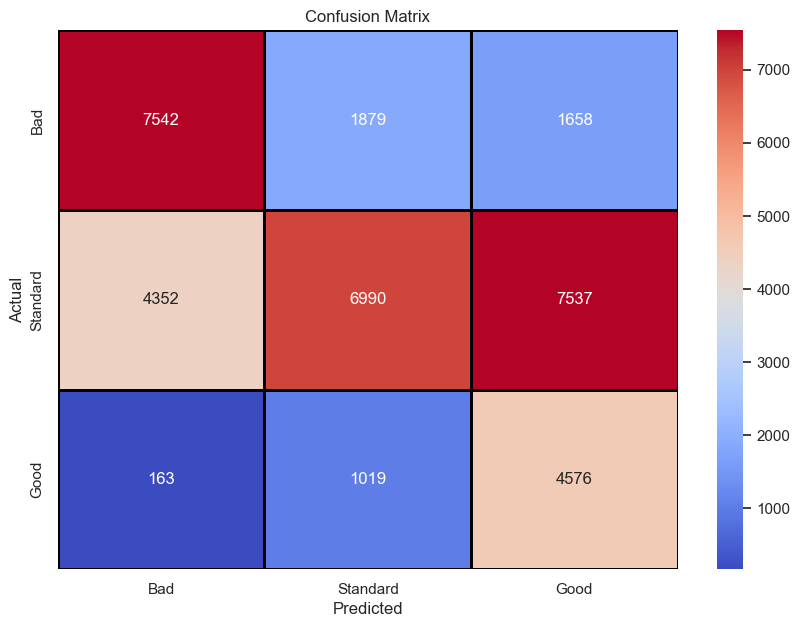

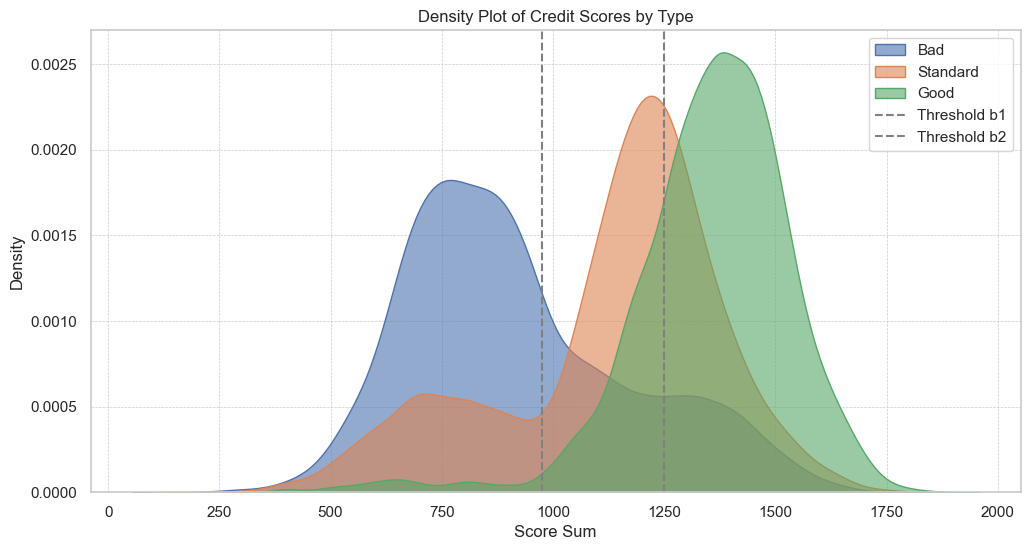

In [62]:
model = CreditScoreModel('Data/train-2.csv')
model.columns_to_process_num = ['Interest_Rate'] # Histogramas
model.run_full_analysis() # Accuracy modelo, graficas de densidad, e histograma de las diferencias entre las variables predichas y las reales